In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.linalg import cho_solve
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

Correlation length

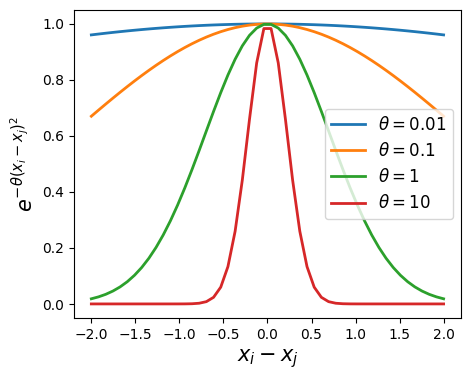

In [2]:
shift = np.linspace(-2, 2, 50)
thetas = np.array([0.01,0.1,1,10])

# Calculate correlation under various theta values
corrs = [np.exp(-theta*shift**2) for theta in thetas]

# Visualize results
fig, ax = plt.subplots(figsize=(5,4))

# Define labels
labels = [r'$\theta=0.01$', r'$\theta=0.1$', r'$\theta=1$', r'$\theta=10$']

for i in range(thetas.shape[0]):
    ax.plot(shift, corrs[i], label=labels[i], lw=2)
ax.legend(fontsize=12)
ax.set_xlabel(r'$x_i-x_j$', fontsize=15)
ax.set_ylabel(r'$e^{-\theta (x_i-x_j)^2}$', fontsize=15);
plt.savefig('./images/Correlation_strength')

Gaussian Process class

In [3]:
class GaussianProcess:
    """A Gaussian Process class that trains and exploits 
    a Gaussian Process model."""

    def __init__(self, n_restarts, optimizer):
        """Initialize a Gaussian Process model
        
        Args:
        - n_restarts (int): Number of restarts of the local optimizer
        - optimizer (str): Algorithm of local optimization
        """
        self.n_restarts = n_restarts
        self.optimizer = optimizer
       
    def Corr(self, X1, X2, theta):
        """Construct the correlation matrix between X1 and X2
        
        Args:
        - X1, X2 (2D arrays): Input data of shape (n_samples, n_features)
        - theta (array): Correlation lengths for different dimensions
        
        Returns:
        - K (array): The correlation matrix
        """
        K = np.zeros((X1.shape[0], X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
            
        return K
 
    def Neglikelihood(self, theta):
        """Negative likelihood function
        
        Args:
        - theta (array): Correlation lengths for different dimensions
        
        Returns:
        - LnLike (float): Likelihood value
        """
        theta = 10**theta    # Correlation length
        n = self.X.shape[0]  # Number of training instances
        one = np.ones((n,1))      # Vector of ones
        
        # Construct correlation matrix
        K = self.Corr(self.X, self.X, theta) + np.eye(n)*1e-10
        L = np.linalg.cholesky(K)
        
        # Mean estimation
        mu = (one.T @ (cho_solve((L, True), self.y))) / \
            (one.T @ (cho_solve((L, True), one)))
        
        # Variance estimation
        SigmaSqr = (self.y-mu*one).T @ (cho_solve((L, True), self.y-mu*one)) / n
        
        # Compute log-likelihood
        LnDetK = 2*np.sum(np.log(np.abs(np.diag(L))))
        LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*LnDetK
        
        # Update attributes
        self.K, self.L, self.mu, self.SigmaSqr = K, L, mu, SigmaSqr
        
        return -LnLike.flatten()
        
    def fit(self, X, y):
        """GP model training
        
        Args:
        - X (2D array): Input data of shape (n_samples, n_features)
        - y (2D array): Target labels of shape (n_samples, 1)
        """
        self.X, self.y = X, y
        lb, ub = -3, 2
        
        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)
        
        # Scale random samples to the given bounds 
        initial_points = (ub-lb)*lhd + lb
        
        # Create A Bounds instance for optimization
        bnds = Bounds(lb*np.ones(X.shape[1]),ub*np.ones(X.shape[1]))
        
        # Run local optimizer on all points
        opt_para = np.zeros((self.n_restarts, self.X.shape[1]))
        opt_func = np.zeros((self.n_restarts, 1))
        for i in range(self.n_restarts):
            res = minimize(self.Neglikelihood, initial_points[i,:], method=self.optimizer,
                bounds=bnds)
            opt_para[i,:] = res.x
            opt_func[i,:] = res.fun
        
        # Locate the optimum results
        self.theta = opt_para[np.argmin(opt_func)]
        
        # Update attributes
        self.NegLnlike = self.Neglikelihood(self.theta)
        
    def predict(self, X_test):
        """GP model predicting
        
        Args:
        - X_test (2D array): Test set of shape (n_samples, n_features)
        
        Returns:
        - f (array): GP predictions
        - SSqr (array): Prediction variances
        """
        n = self.X.shape[0]
        one = np.ones((n,1))
        
        # Construct correlation matrix between test and train data
        k = self.Corr(self.X, X_test, 10**self.theta)
        
        # Mean prediction
        f = self.mu + k.T @ (cho_solve((self.L, True), self.y-self.mu*one))
        
        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(k.T @ (cho_solve((self.L, True), k))))
        
        return f.flatten(), SSqr.flatten()
    
    def score(self, X_test, y_test):
        """Calculate root mean squared error
        
        Args:
        - X_test (2D array): Test set of shape (n_samples, n_features)
        - y_test (array): Test labels of shape (n_samples, )
        
        Returns:
        - RMSE (float): The root mean square error
        """
        y_pred, SSqr = self.predict(X_test)
        RMSE = np.sqrt(np.mean((y_pred-y_test)**2))
        
        return RMSE


1D function test

In [4]:
# Define the 1D test function
def Test_1D(X):
    """1D Test Function"""
    y = (X * 6 - 2)**2 * np.sin(X * 12 - 4)
    return y

Test RMSE: 6.269640


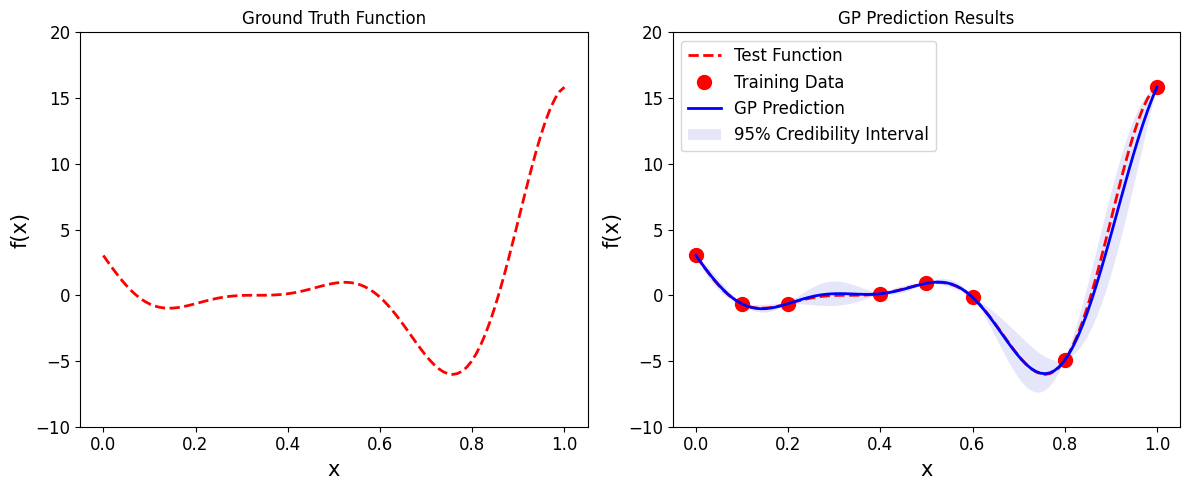

In [6]:
# Define parameters
n_restarts = 10
optimizer = 'L-BFGS-B'

# Generate data
X = np.linspace(0.0, 1, 100).reshape(-1, 1)
y = Test_1D(X)

# Create subplots for both plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth function
ax1.plot(X, y, "r--", lw=2)
ax1.tick_params(axis="both", which="major", labelsize=12)
ax1.set_xlabel("x", fontsize=15)
ax1.set_ylabel("f(x)", fontsize=15)
ax1.set_ylim([-10, 20])
ax1.set_title("Ground Truth Function")

# Define training and testing data
X_train = np.array([0.0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]).reshape(-1, 1)
y_train = Test_1D(X_train)
X_test = np.linspace(0.0, 1, 100).reshape(-1, 1)
y_test = Test_1D(X_test)

# Train Gaussian Process model
GP = GaussianProcess(n_restarts=n_restarts, optimizer=optimizer)
GP.fit(X_train, y_train)

# Test Gaussian Process model
RMSE = GP.score(X_test, y_test)
print("Test RMSE: {:.6f}".format(RMSE))

# Predict and plot results
y_pred, y_pred_SSqr = GP.predict(X_test)
ax2.plot(X_test, y_test, "r--", lw=2, label="Test Function")
ax2.plot(X_train, y_train, "ro", markerfacecolor="r", markersize=10, label="Training Data")
ax2.plot(X_test, y_pred, "b-", lw=2, label="GP Prediction")
ax2.fill_between(
    X_test.flatten(),
    y_pred - 1.96 * np.sqrt(y_pred_SSqr),
    y_pred + 1.96 * np.sqrt(y_pred_SSqr),
    facecolor="lavender",
    label="95% Credibility Interval",
)
ax2.tick_params(axis="both", which="major", labelsize=12)
ax2.set_xlabel("x", fontsize=15)
ax2.set_ylabel("f(x)", fontsize=15)
ax2.set_ylim([-10, 20])
ax2.set_title("GP Prediction Results")
ax2.legend(loc="upper left", prop={"size": 12})

# Tight layout and save figures
plt.tight_layout()
plt.savefig("./images/Test_1D_results")


2D Test

In [7]:
def Test_2D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + 200*(X[:,1]-X[:,0]**2)**2
    
    return y

Test RMSE: 9.603220


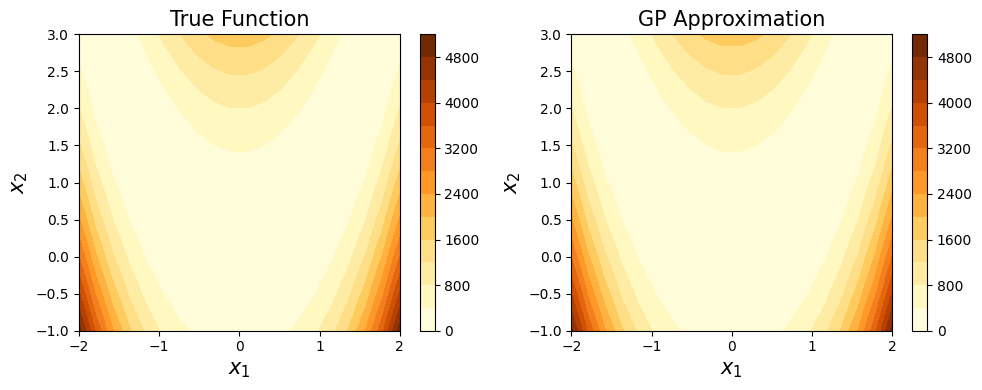

In [8]:
# Training data
sample_num = 25
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub - lb) * lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1, 1)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1)))
y_test = Test_2D(X_test)


# GP model training
pipe = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("GP", GaussianProcess(n_restarts=10, optimizer="L-BFGS-B")),
    ]
)
pipe.fit(X_train, y_train)

# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

# GP model validation
RMSE = pipe.score(X_test, y_test)
print("Test RMSE: {:.6f}".format(RMSE))

# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
title = ["True Function", "GP Approximation"]
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(
        X_test[:, 0].reshape(20, -1),
        X_test[:, 1].reshape(20, -1),
        display_y[i].reshape(20, -1),
        levels=15,
        cmap="YlOrBr",
    )
    ax[i].set_xlabel(r"$x_1$", fontsize=15)
    ax[i].set_ylabel(r"$x_2$", fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])

plt.tight_layout()
plt.savefig("./images/Test_2D_results")
